In [1]:
import numpy as np
import pandas as pd
from analysis_utils import compute_cortical_emp_sim_alff_correlation, compute_cortical_emp_sim_falff_correlation

from paths import Paths

In [23]:

pid = 'sub-1198'
trad_emp_dir = f'{Paths.RESULTS}/{pid}/traditional_emp_results.npz'
trad_emp_data = np.load(trad_emp_dir)
trad_emp_fc = trad_emp_data['FC']
trad_emp_fcd = trad_emp_data['FCD']
trad_emp_alff = trad_emp_data['ALFF']

emp_data_dir = f'{Paths.RESULTS}/{pid}/emp_results.npz'
emp_data = np.load(emp_data_dir)
emp_fc = emp_data['FC']
emp_fcd = emp_data['FCD']
emp_alff = emp_data['ALFF']

sim_dir = f'{Paths.RESULTS}/{pid}/sim_results.npz'
sim_data = np.load(sim_dir)
sim_fc = sim_data['FC']
sim_fcd = sim_data['FCD']
sim_alff = sim_data['ALFF']
params = sim_data['params']
sim_bolds_file = f'{Paths.RESULTS}/{pid}/JJa_bold_all.npz'
sim_bolds = np.load(sim_bolds_file)['bold']



In [49]:
sim_fcd.shape

(24310, 1000)

In [67]:
np.sum((sim_fcd[:,0] - np.mean(sim_fcd[:,0]))**2)/np.count_nonzero(sim_fcd[:,0])

np.float64(0.10272380591746268)

In [ ]:
sim_gbc = np.mean(sim_fc,axis=0)
sim_var_fcd = np.var(sim_fcd,axis=0))
emp_gbc = np.mean(trad_emp_fc)
emp_var_fcd = np.var(trad_emp_fcd)
alff_corr = compute_cortical_emp_sim_alff_correlation(trad_emp_dir, sim_dir)
falff_corr = compute_cortical_emp_sim_falff_correlation(trad_emp_dir, sim_dir)

In [4]:
def reconstruct_fc(fc_ut, n_regions):
    """
    fc_ut: (E, S) upper triangle (k=1)
    n_regions: R

    returns: (R, R, S)
    """
    S = fc_ut.shape[1]
    fc = np.zeros((n_regions, n_regions, S))

    triu_idx = np.triu_indices(n_regions, k=1)

    for s in range(S):
        fc[triu_idx[0], triu_idx[1], s] = fc_ut[:, s]
        fc[triu_idx[1], triu_idx[0], s] = fc_ut[:, s]  # symmetry
        np.fill_diagonal(fc[:, :, s], 1.0)

    return fc

def reconstruct_fcd(fcd_ut, n_windows):
    """
    fcd_ut: (E_fcd, S)
    n_windows: W

    returns: (W, W, S)
    """
    S = fcd_ut.shape[1]
    fcd = np.zeros((n_windows, n_windows, S))

    triu_idx = np.triu_indices(n_windows, k=1)

    for s in range(S):
        fcd[triu_idx[0], triu_idx[1], s] = fcd_ut[:, s]
        fcd[triu_idx[1], triu_idx[0], s] = fcd_ut[:, s]

    return fcd



np.float64(0.4290050911130247)

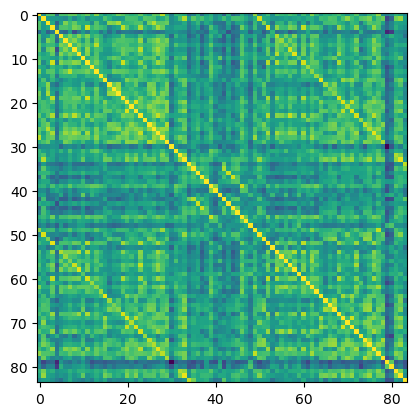

In [8]:
import matplotlib.pyplot as plt
emp_fc_mat = reconstruct_fc(emp_data['FC'], 84)
plt.imshow(emp_fc_mat)
np.mean(emp_fc_mat)


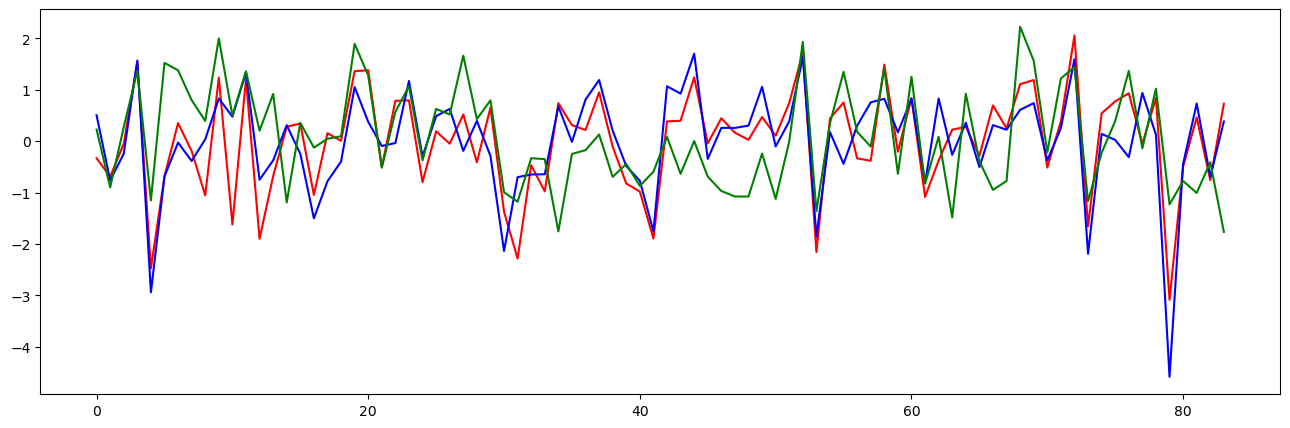

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,5))
plt.plot(trad_emp_alff, color='red')
plt.plot(emp_alff, color='blue')
plt.plot(sim_alff[:84,20], color='green');

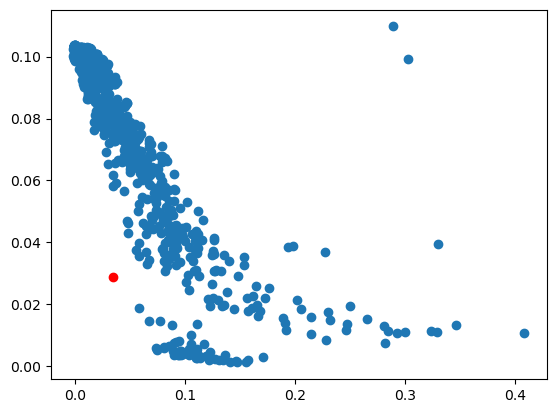

In [61]:
import matplotlib.pyplot as plt
plt.scatter(sim_gbc, sim_var_fcd)
plt.scatter(emp_gbc, emp_var_fcd, color='red');

In [8]:
import seaborn as sns

In [62]:
import pandas as pd
df = pd.DataFrame({'GBC': sim_gbc, 'VAR_FCD': sim_var_fcd, 'ALFF_CORR':alff_corr, 'fALFF_CORR':falff_corr, 'mean': params[:,0], 'std': params[:,1], 'we': params[:,2]})

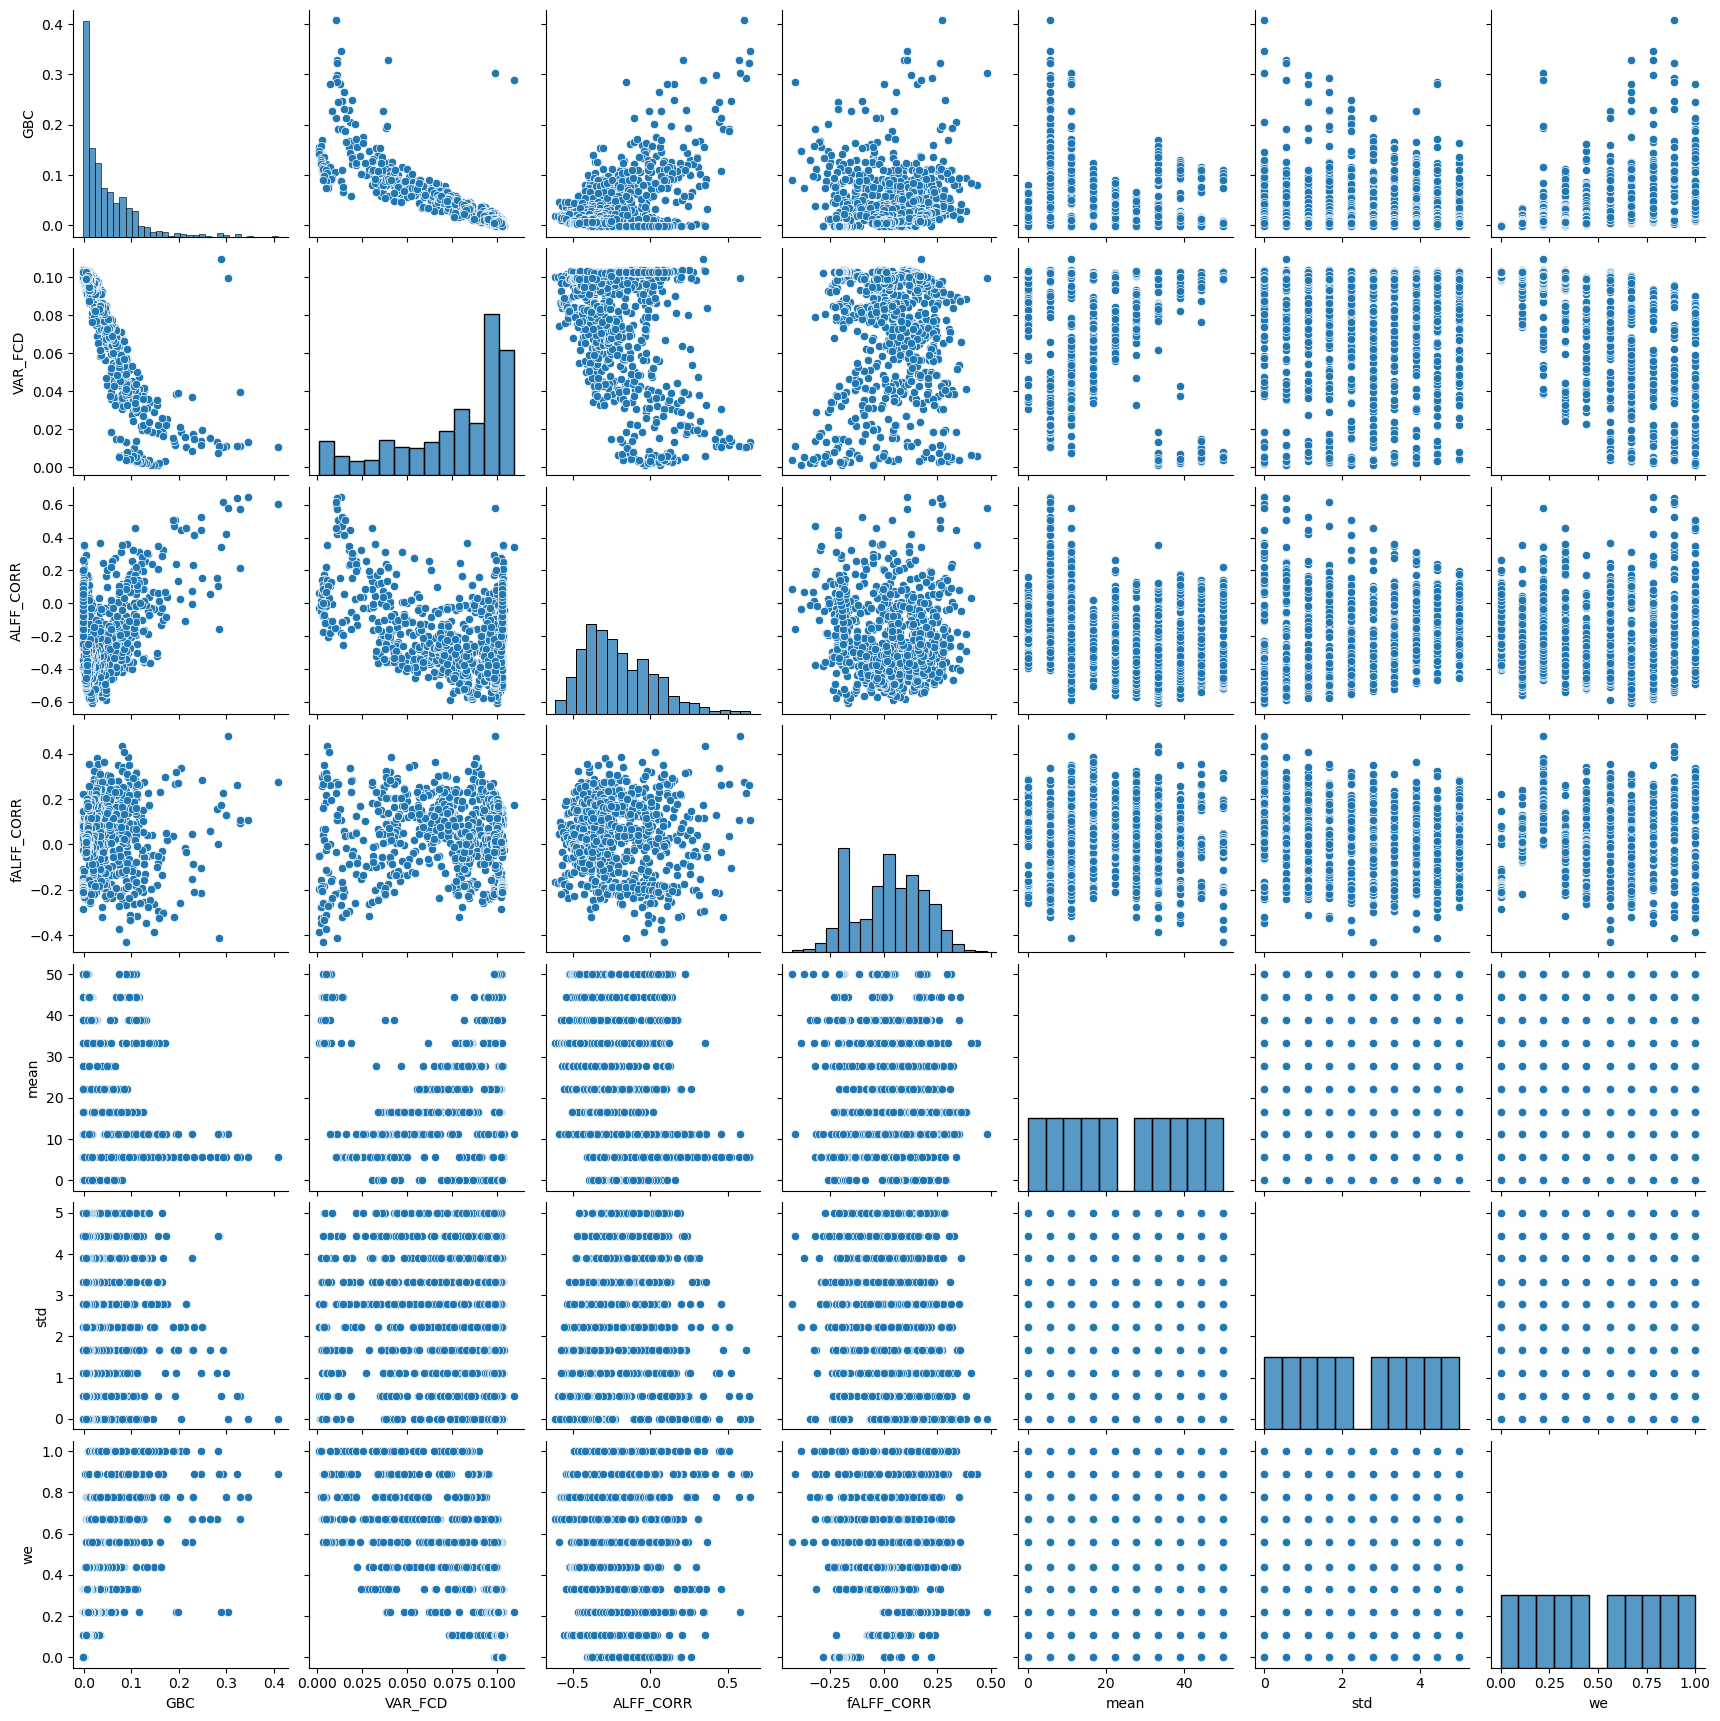

In [56]:
import seaborn as sns
sns.pairplot(df)

In [12]:
from scripts.plot_utils import basic_3d_sweep_plot

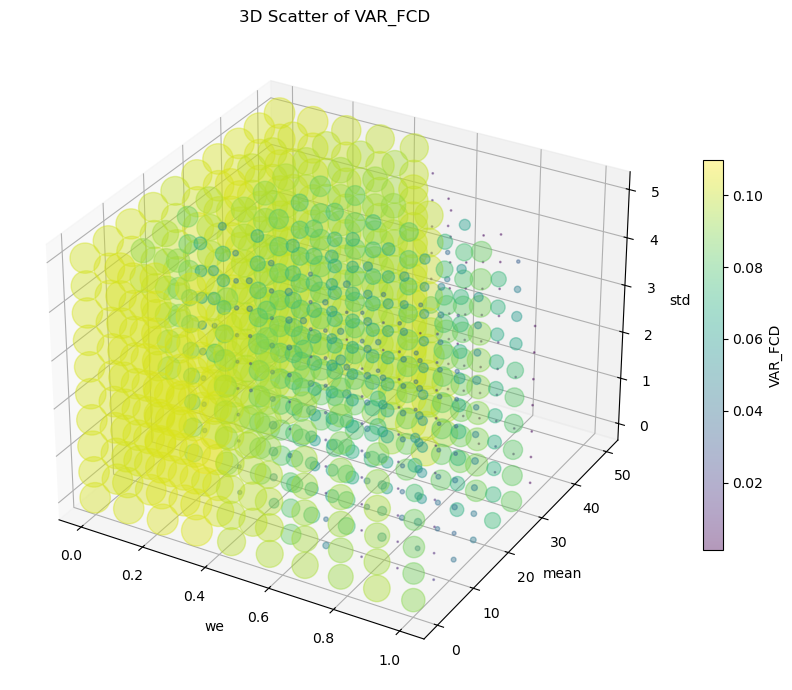

In [63]:
basic_3d_sweep_plot(df, 'we', 
    'mean', 'std', 'VAR_FCD')

In [14]:
np.unique(params[:,2])

array([0.  , 0.11, 0.22, 0.33, 0.44, 0.56, 0.67, 0.78, 0.89, 1.  ])

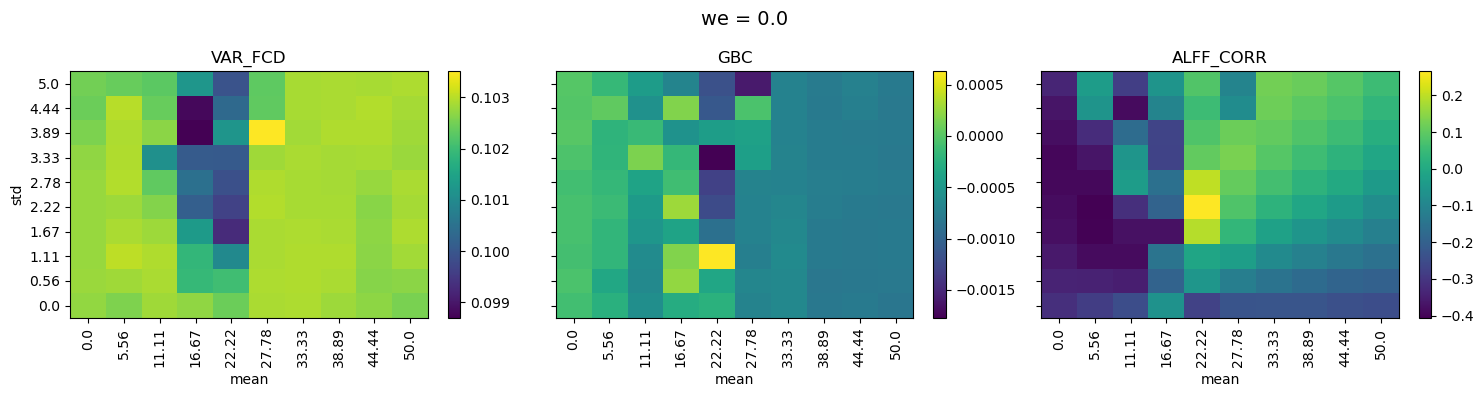

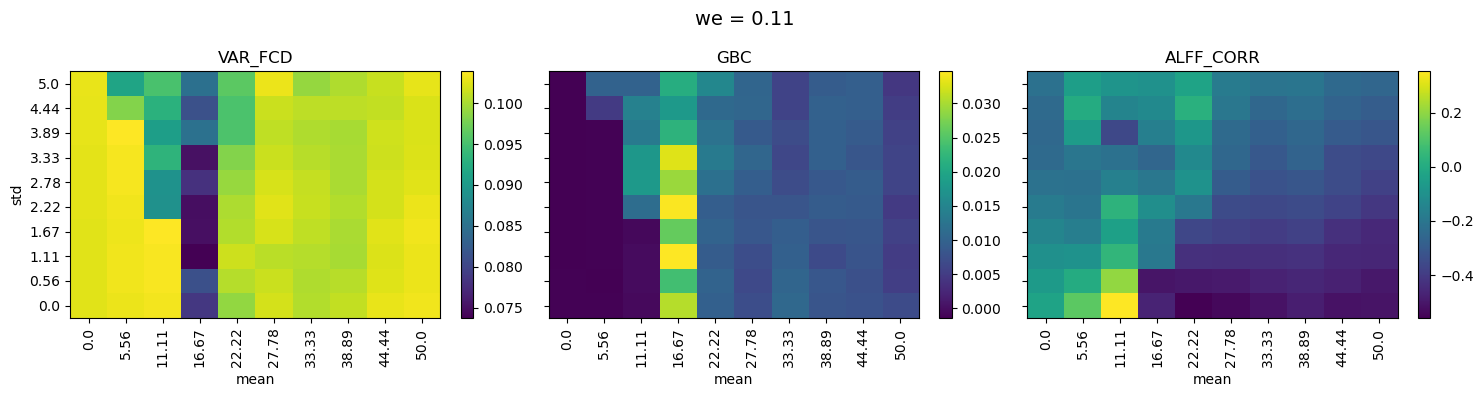

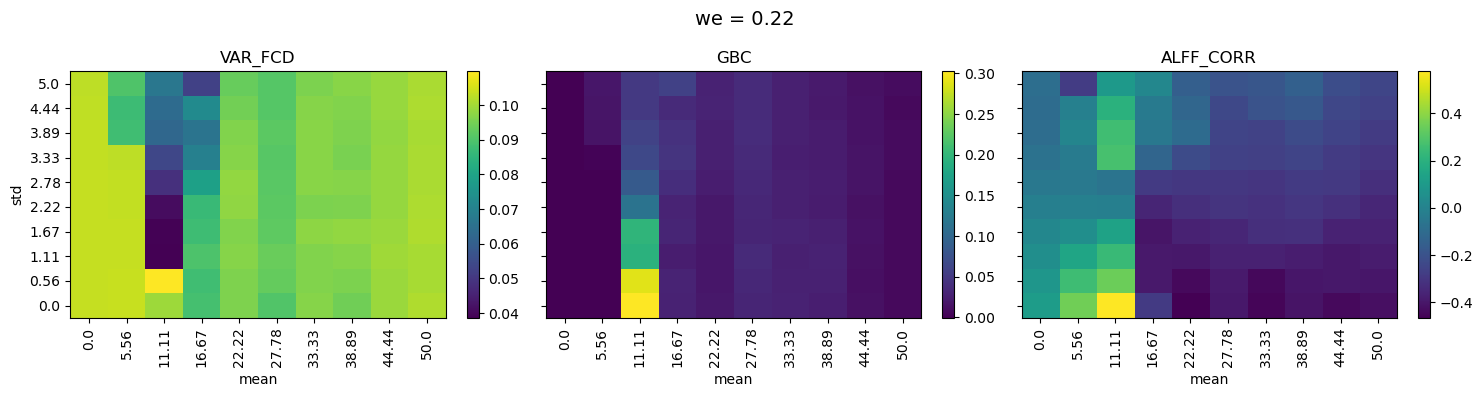

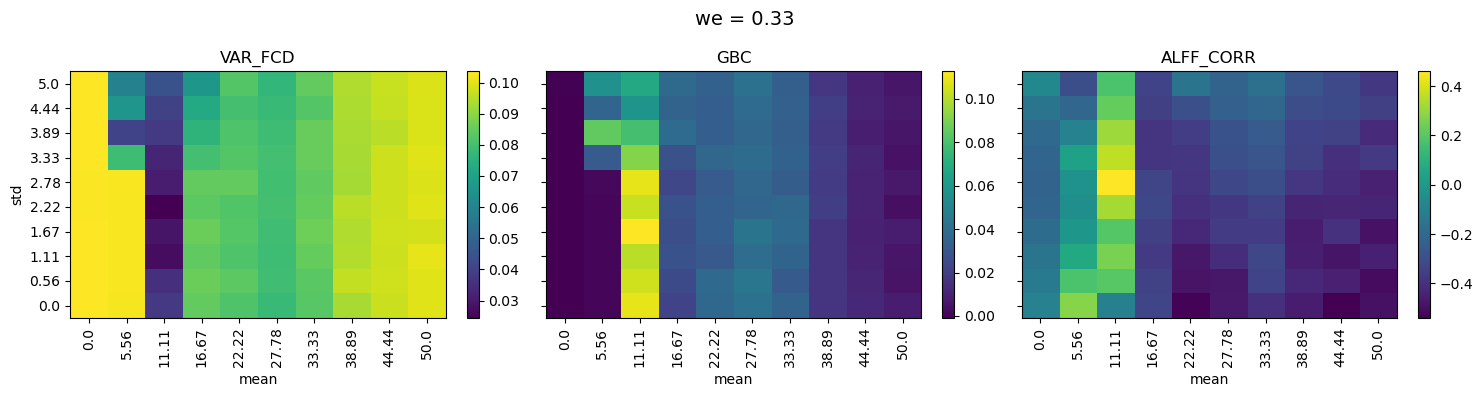

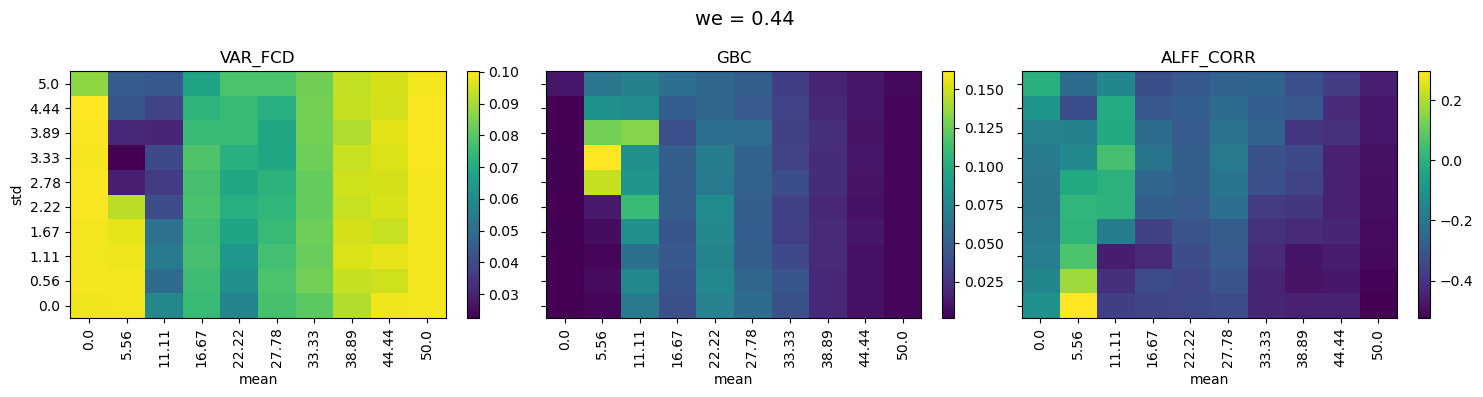

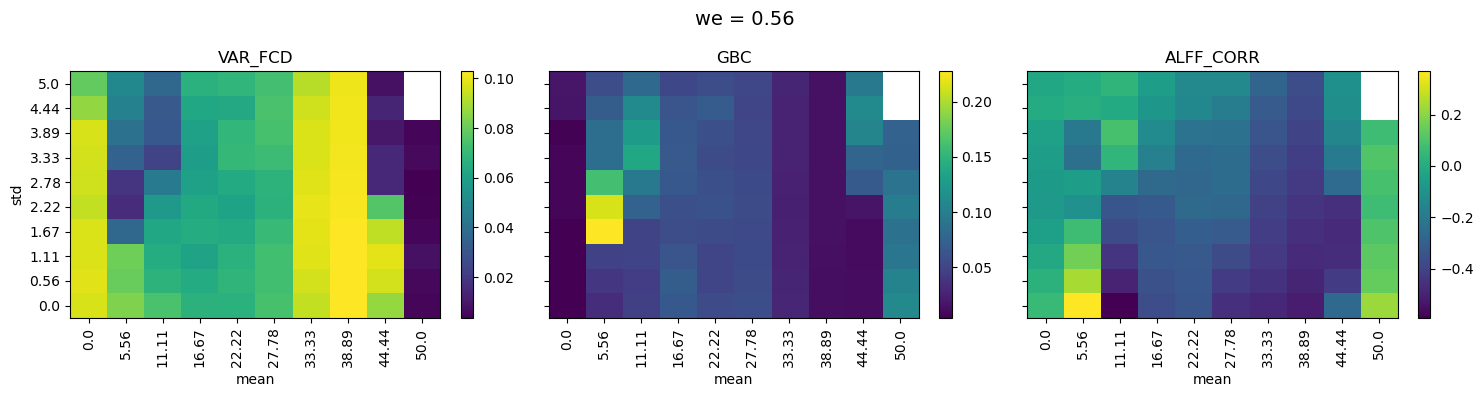

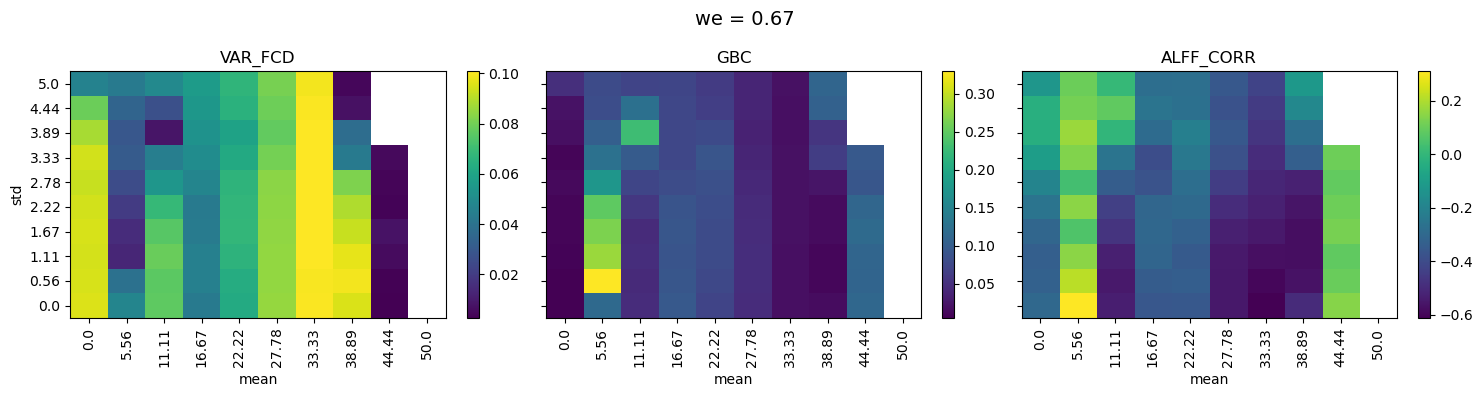

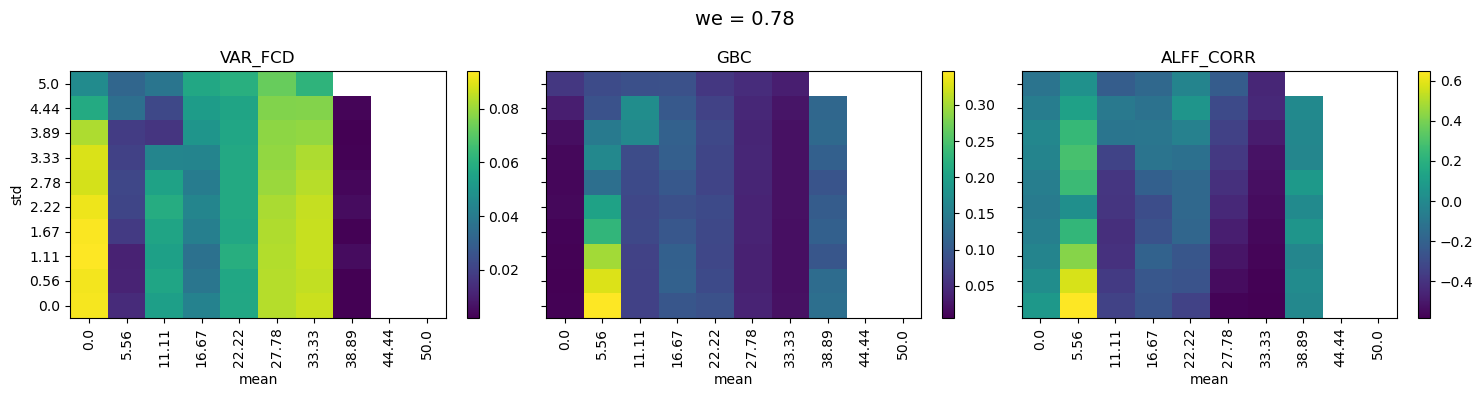

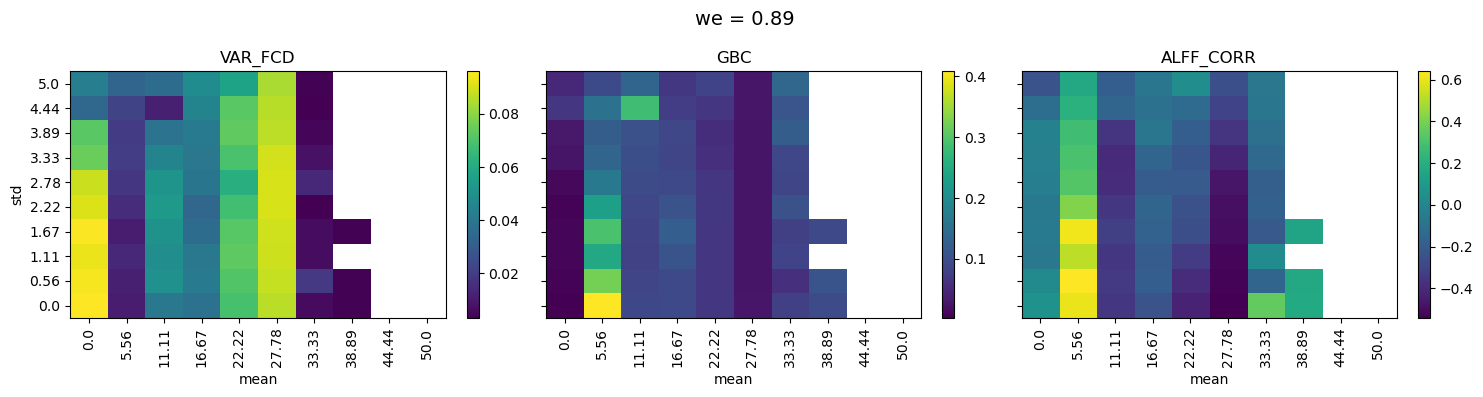

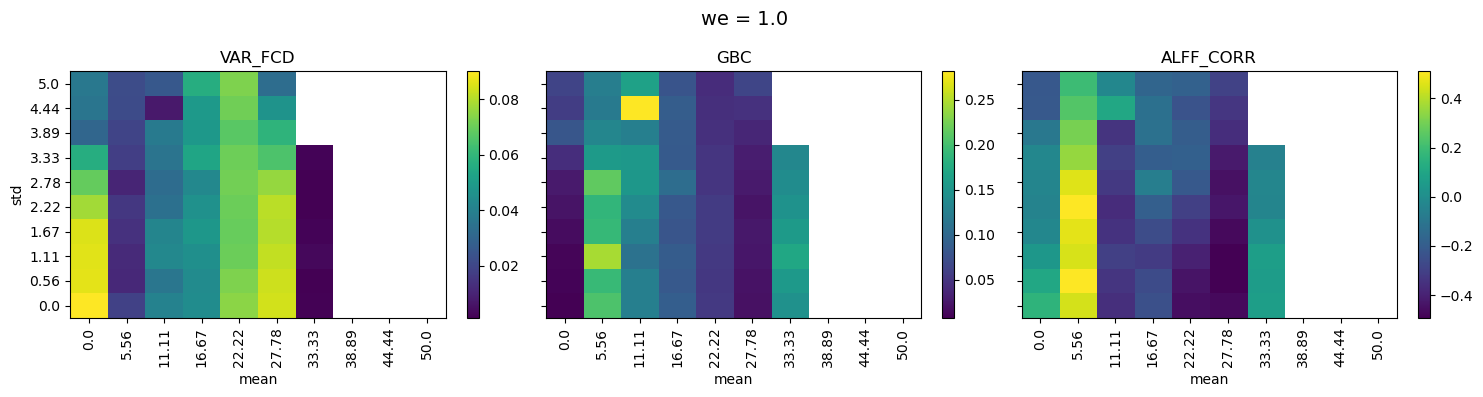

In [15]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["VAR_FCD", "GBC", "ALFF_CORR"]

for we in np.unique(params[:, 2]):

    fig, axes = plt.subplots(
        1, len(metrics),
        figsize=(5 * len(metrics), 4),
        sharex=True,
        sharey=True
    )

    for ax, metric in zip(axes, metrics):
        dfplot = df[df["we"] == we]
        dfplot = dfplot.pivot(
            columns="mean",
            index="std",
            values=metric
        )

        im = ax.imshow(
            dfplot.values,
            aspect="auto",
            origin="lower"
        )

        ax.set_title(metric)
        fig.colorbar(im, ax=ax, fraction=0.046)

        # ticks
        ax.set_xticks(np.arange(len(dfplot.columns)))
        ax.set_xticklabels(dfplot.columns, rotation=90)

        ax.set_yticks(np.arange(len(dfplot.index)))
        ax.set_yticklabels(dfplot.index)

        ax.set_xlabel("mean")

    axes[0].set_ylabel("std")
    fig.suptitle(f"we = {we}", fontsize=14)

    plt.tight_layout()
    plt.show()


In [96]:
np.intersect1d(np.where(params[:,0]==0.0), np.where(params[:,1]==5.0))

array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

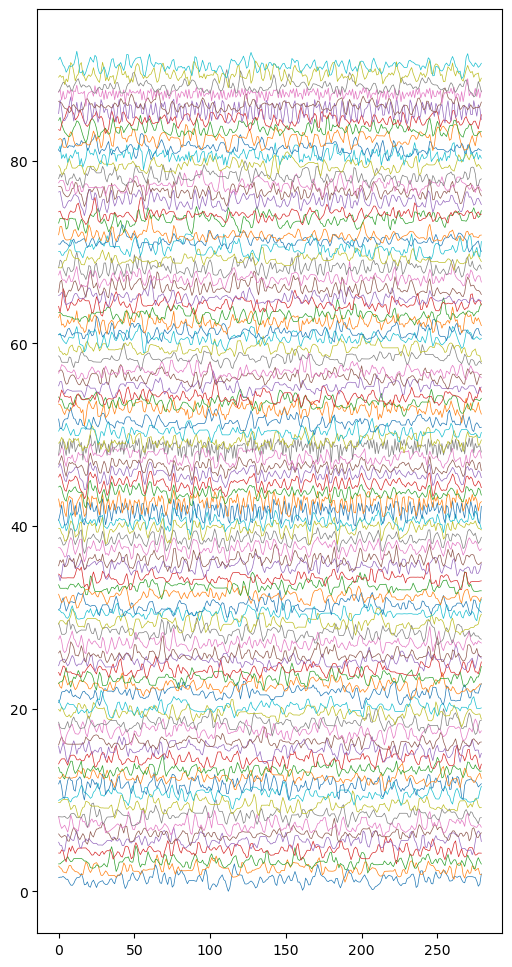

In [98]:
from plot_utils import plot_bold

plot_bold(sim_bolds[:,:,99])

In [149]:
def find_closest_simulation(df, col1, col2, emp_val1, emp_val2):

    dist = np.sqrt((df[col1] - emp_val1)**2 + (df[col2] - emp_val2)**2 + 0.01*(1-df["ALFF_CORR"])**2)

    best_idx = dist.idxmin()
    sim1 = df.loc[best_idx, col1]
    sim2 = df.loc[best_idx, col2]

    err1 = abs(sim1 - emp_val1) / ((abs(sim1) + abs(emp_val1)) / 2)
    err2 = abs(sim2 - emp_val2) / ((abs(sim2) + abs(emp_val2)) / 2)

    return df.loc[best_idx], err1, err2 

In [150]:
index, e1, e2 = find_closest_simulation(df, 'GBC', 'VAR_FCD', emp_gbc, emp_var_fcd)

In [151]:
index

GBC            0.057879
VAR_FCD        0.039706
ALFF_CORR      0.221994
fALFF_CORR    -0.176982
mean          11.110000
std            4.440000
we             0.330000
Name: 283, dtype: float64

In [136]:
df[df['ALFF_CORR']==df['ALFF_CORR'].max()]

,GBC,VAR_FCD,ALFF_CORR,fALFF_CORR,mean,std,we
107,0.346257,0.013339,0.646865,0.10932,5.56,0.0,0.78


<Axes: xlabel='mean', ylabel='GBC'>

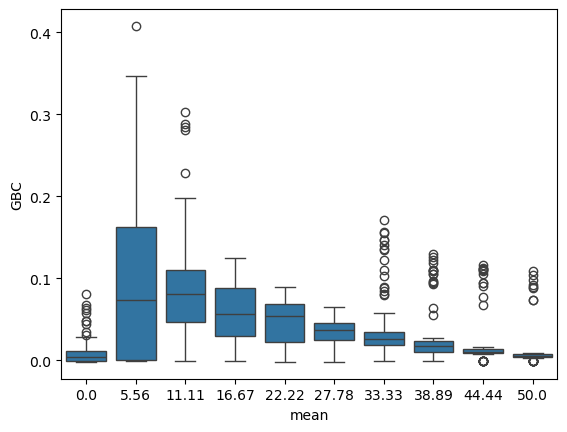

In [163]:
sns.boxplot(data=df,
            x='mean',
            y='GBC')